In [108]:
using Distributions 
using IntervalSets
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Random123
using HCubature
using HDF5
using JLD2
using BAT
using LaTeXStrings
using KernelDensity

In [ ]:
# using Plots

In [111]:
using PyPlot

plt = PyPlot

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)


function plot_tree(tree, axes::Array{Int64,1}, plot_ax; kwargs...)
    if tree.terminated_leaf == true
        r = matplotlib.patches.Rectangle([tree.bounds[axes[1],1],tree.bounds[axes[2],1]], tree.bounds[axes[1],2]-tree.bounds[axes[1],1], tree.bounds[axes[2],2]-tree.bounds[axes[2],1], fill=false, linewidth=0.8, color="black", alpha=1,; kwargs...,) #alpha=0.0, facecolor=color[i], edgecolor='k', linewidth=2.0)
        plot_ax.add_patch(r)
    else
        plot_tree(tree.left_child, axes, plot_ax; kwargs...)
        plot_tree(tree.right_child, axes, plot_ax; kwargs...)
    end
end

figsize = 337.323 # pt

function set_size(width; ratio=:golden, fraction=1)
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    if ratio == :golden
        golden_ratio = (5^0.5 - 1) / 2
    else 
        golden_ratio = ratio
    end

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim
end

equal_size = set_size(figsize, ratio=1)
golden_size = set_size(figsize)

(4.667538397675384, 2.8846973735586108)

In [115]:
equal_size

(4.667538397675384, 4.667538397675384)

In [114]:
golden_size

(4.667538397675384, 2.8846973735586108)

In [3]:
# Report Example:

sigma_1 = [0.32716446841097613 0.17276467616026275; 0.17276467616026275 0.33056237691918017]
sigma_3 = [0.01942201849281335 -0.003187584896683795; -0.003187584896683795 0.017175237584791444]

N = 2 
min_v = -20.
max_v = 20.
lgV = N*log(max_v-min_v); 

f(x;μ=[0, 0], sigma=sigma_1) = pdf(MvNormal(μ, sigma), x)

g(x) = (1/2.08)*(f(x, μ=[3.5, 3.5], sigma=sigma_1) + f(x, μ=[-3.5, -3.5], sigma=sigma_1) + 0.08*f(x, μ=[3.5, -3.5], sigma=sigma_3) + 0.08*f(x, μ=[-3.5, 3.5], sigma=sigma_3))

g (generic function with 1 method)

In [4]:
0.04/2.08

0.019230769230769232

In [5]:
likelihood = params -> LogDVal((log(g(params.a))))
prior = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],);
posterior = PosteriorDensity(likelihood, prior);

# Sampling

In [63]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCMultiCycleBurnin(
        nsteps_per_cycle = 400,
        max_ncycles = 20
    )


sampling_alg = MCMCSampling(mcalg=sampler, burnin=burnin_1, 
    strict=false, nchains = 10, nsteps =  10^4, trafo = NoDensityTransform(),);

The same with exploration sampler

In [81]:
# MetropolisHastings: 

burnin_2 = MCMCMultiCycleBurnin(
        nsteps_per_cycle = 10,
        max_ncycles = 10
    )

tuning_2 = AdaptiveMHTuning(
    λ = 0.5,
    α = 0.01..0.03,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5
)

init_2 = MCMCChainPoolInit(
    init_tries_per_chain = 8..20,
    nsteps_init = 15,
)

exploration_sampler = MetropolisHastings(tuning = tuning_2)

exploration_alg = MCMCSampling(mcalg=exploration_sampler, 
    init = init_2, 
    nsteps = 200,  
    nchains= 80, 
    burnin=burnin_2, trafo = NoDensityTransform(), strict=false);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [82]:
partitioner = BAT.KDTreePartitioning(
        partition_dims = [1,2,], # dimension indices that are considered for partition
        extend_bounds=true # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [83]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

Finally, `PartitionedSampling` can be defined using settings: 

In [84]:
algorithm = PartitionedSampling(
        sampler = sampling_alg,
        exploration_sampler = exploration_alg,
        partitioner = partitioner,
        integrator = integrator,
        npartitions = 30, 
        nmax_resampling = 1
    );

In [85]:
# output_sp_ms = bat_sample(posterior, algorithm);

# samples_3 = output_sp_ms.result;

┌ Info: Initializing new RNG of type Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:40
┌ Info: Initializing new RNG of type Philox4x{UInt64, 10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm DensityIdentityTransform()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 80 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 80 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 80 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 

In [98]:
# JLD2.@save "../data/Benchmark-4/samples_fig-1.jld2" output_sp_ms

In [99]:
JLD2.@load "../data/Benchmark-4/samples_fig-1.jld2" output_sp_ms

# samples_3 = output_sp_ms.result;

In [88]:
flat_samples = flatview(unshaped.(samples_3.v))
exp_x = flatview(unshaped.(output_sp_ms.exp_samples.v))[1,:]
exp_y = flatview(unshaped.(output_sp_ms.exp_samples.v))[2,:]

histogram_2D_wr = fit(Histogram, (flat_samples[1,:],flat_samples[2,:]), weights(samples_3.weight), nbins=140)
histogram_2D_wr = normalize(histogram_2D_wr, mode=:pdf);

In [89]:
weights_wo = Float64[]

for (enum, ind) in enumerate(output_sp_ms.info.samples_ind)
    subs_ind = enum
    smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
    smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
    smpl_trunc = samples_3[smpl_ind]
    smpl_int = output_sp_ms.info.density_integral[subs_ind].val
#     tmp = round.(Integer, smpl_tot_weight .* smpl_trunc.weight ./ smpl_int)
    tmp =  smpl_tot_weight .* smpl_trunc.weight ./ smpl_int
    append!(weights_wo, tmp)
end

@show unique(weights_wo)[1:5]

histogram_2D_wo = fit(Histogram, (flat_samples[1,:],flat_samples[2,:]), weights(weights_wo), nbins=200)
histogram_2D_wo = normalize(histogram_2D_wo, mode=:pdf);

(unique(weights_wo))[1:5] = [4.0, 1.0, 5.0, 2.0, 3.0]


In [90]:
exp_color = "k" #PyPlot.cm.RdYlBu_r(0,0,)

"k"

In [91]:
levels_quantiles = [0.4, 0.7, 0.8, 0.9, 0.99, 1,]
colors = vcat([1 1 1 1], plt.cm.Blues(range(0, stop=0.9, length=length(levels_quantiles)))[2:end,:]);
# colors = plt.cm.Blues(range(0.08, stop=1, length=length(levels_quantiles)))

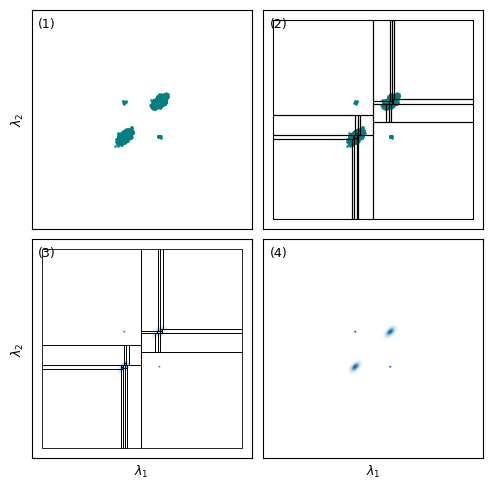

PyObject Text(26.099999999999994, 0.5, '$\\lambda_2$')

In [92]:
fig, ax = plt.subplots(2,2, figsize=(5.826767123287671, 5.826767123287671), sharex=true, sharey=true)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

ax[1,1].scatter(exp_x, exp_y, color="teal", s=0.8, alpha=0.9) #midnightblue
ax[1,1].text(0.03,0.92, "(1)",transform=ax[1,1].transAxes)

ax[1,2].scatter(exp_x, exp_y, color="teal", s=0.8, alpha=0.9) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]
ax[1,2].text(0.03,0.92,"(2)", transform=ax[1,2].transAxes)
plot_tree(output_sp_ms.part_tree, [1,2], ax[1,2], color="black", linewidth=0.8)

ax[2, 1].pcolormesh(midpoints(histogram_2D_wo.edges[1]), midpoints(histogram_2D_wo.edges[2]), 
    replace(histogram_2D_wo.weights', 0=>NaN), cmap=ColorMap(colors), rasterized=true) # cmap=ColorMap(colors)

plot_tree(output_sp_ms.part_tree, [1,2], ax[2, 1], linewidth=0.6, color="black", alpha=1)
ax[2,1].text(0.03,0.92,"(3)", transform=ax[2,1].transAxes)

ax[2,2].pcolormesh(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), 
    replace(histogram_2D_wr.weights', 0=>NaN), cmap=ColorMap(colors), rasterized=true) 
ax[2,2].text(0.03,0.92,"(4)", transform=ax[2,2].transAxes)


ax[1,1].get_xaxis().set_visible(false)
ax[1,2].get_xaxis().set_visible(false)
ax[1,2].get_yaxis().set_visible(false)
ax[2,2].get_yaxis().set_visible(false)

ax[2,2].set_xticks([])
ax[2,2].set_xlabel(L"\lambda_1")

ax[2,1].set_xticks([])
ax[2,1].set_xlabel(L"\lambda_1")

ax[1,1].set_yticks([])
ax[1,1].set_ylabel(L"\lambda_2")

ax[2,1].set_yticks([])
ax[2,1].set_ylabel(L"\lambda_2")

# fig.savefig("../plots/fig-a.png", bbox_inches = "tight", dpi=500)

In [93]:
# kde_mcmc = kde(flat_samples', weights=Weights(samples_3.weight))

In [94]:
flat_gridpoints(grids) = vec(collect(Iterators.product(grids...)))

flat_gridpoints (generic function with 1 method)

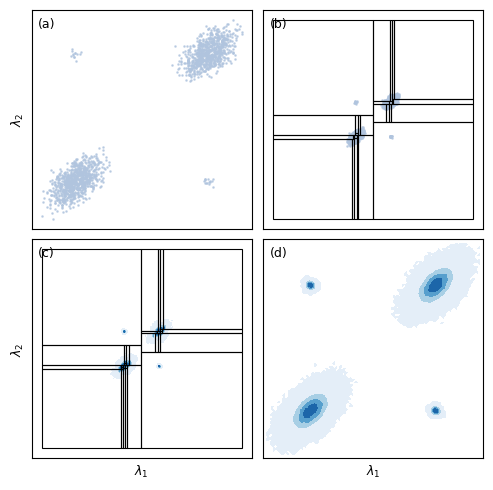

PyObject Text(26.099999999999994, 0.5, '$\\lambda_2$')

In [95]:
fig, ax = plt.subplots(2,2, figsize=(5.826767123287671, 5.826767123287671))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

ax[1,1].scatter(exp_x, exp_y, color="lightsteelblue", s=0.8, alpha=0.7) #midnightblue "teal"
ax[1,1].text(0.03,0.92, "(a)",transform=ax[1,1].transAxes)

ax[1,2].scatter(exp_x, exp_y, color="lightsteelblue", s=0.8, alpha=0.7) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]
ax[1,2].text(0.03,0.92,"(b)", transform=ax[1,2].transAxes)
plot_tree(output_sp_ms.part_tree, [1,2], ax[1,2], color="black", linewidth=0.8)

for (enum, ind) in enumerate(output_sp_ms.info.samples_ind)
    
    subs_ind = enum
    smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
    smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
    smpl_trunc = samples_3[smpl_ind]
    smpl_int = output_sp_ms.info.density_integral[subs_ind].val
    tmp =  smpl_tot_weight .* smpl_trunc.weight ./ smpl_int
    
    flat_samples_tmp = flatview(unshaped.(smpl_trunc.v))
    
    min_x, min_y = minimum(flat_samples_tmp, dims=2)[:,1]
    max_x, max_y = maximum(flat_samples_tmp, dims=2)[:,1]
    
    x_range = range(min_x, stop=max_x, length=20)
    y_range = range(min_y, stop=max_y, length=20)
    grid = flat_gridpoints((x_range, y_range))

    kde_tmp = kde(flat_samples_tmp', weights=Weights(tmp))
    
    z_parallel = [pdf(kde_tmp, x,y) for y in y_range, x in x_range]
    
    levels = collect(range(quantile([z_parallel...], 0.35), stop=maximum(z_parallel), length=5))
    
    ax[2, 1].contourf(x_range, y_range, z_parallel, levels=levels, cmap=ColorMap(colors))
    
end

plot_tree(output_sp_ms.part_tree, [1,2], ax[2, 1], color="black", linewidth=0.8)

ax[2,1].text(0.03,0.92,"(c)", transform=ax[2,1].transAxes)

levels = collect(range(quantile([histogram_2D_wr.weights...], 0.3), stop=maximum(histogram_2D_wr.weights), length=5))
ax[2,2].contourf(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), 
    replace(histogram_2D_wr.weights', 0=>NaN), levels=levels, cmap=ColorMap(colors), rasterized=true) 


ax[2,2].text(0.03,0.92,"(d)", transform=ax[2,2].transAxes)


ax[1,1].get_xaxis().set_visible(false)
ax[1,2].get_xaxis().set_visible(false)
ax[1,2].get_yaxis().set_visible(false)
ax[2,2].get_yaxis().set_visible(false)

ax[2,2].set_xticks([])
ax[2,2].set_xlabel(L"\lambda_1")

ax[2,1].set_xticks([])
ax[2,1].set_xlabel(L"\lambda_1")

ax[1,1].set_yticks([])
ax[1,1].set_ylabel(L"\lambda_2")

ax[2,1].set_yticks([])
ax[2,1].set_ylabel(L"\lambda_2")

# fig.savefig("../plots/fig-a.png", bbox_inches = "tight", dpi=500)

In [96]:
x_r_tmp = range(-8, stop=8, length=100)
y_r_tmp = range(-8, stop=8, length=100)

z = g.([x,y] for x in x_r_tmp, y in y_r_tmp)

levels_c = collect(range(quantile([z ...], 0.81), stop=maximum(z), length=5))

5-element Vector{Float64}:
 4.947995565111128e-7
 0.08259761900486076
 0.165194743210165
 0.24779186741546927
 0.3303889916207735

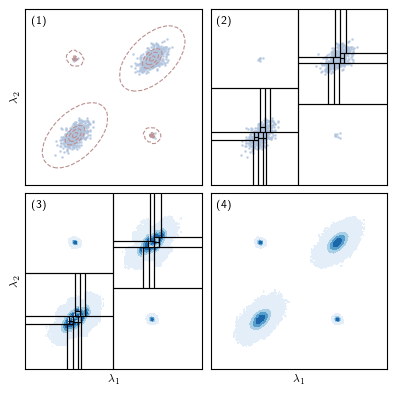

In [113]:
fig, ax = plt.subplots(2,2, figsize=equal_size, sharex=true, sharey=true)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

ax[1,1].contour(x_r_tmp, y_r_tmp, z', levels=levels_c, 
    colors="rosybrown", rasterized=true, linewidths=0.8, linestyles="dashed") # cmap=ColorMap(colors)
# ax[1,1].scatter(exp_x[1:2:end], exp_y[1:2:end], color="lightsteelblue", s=0.7, alpha=1) #midnightblue "teal"
ax[1,1].scatter(exp_x[1:2:end], exp_y[1:2:end], color="lightsteelblue", s=0.8, alpha=0.7) #midnightblue "teal"
ax[1,1].text(0.03,0.92, "(1)",transform=ax[1,1].transAxes)

ax[1,2].scatter(exp_x[1:2:end], exp_y[1:2:end], color="lightsteelblue", s=0.8, alpha=0.7) #color=get_cmap("tab10", 1) | ColorMap("tab10").colors[1]
ax[1,2].text(0.03,0.92,"(2)", transform=ax[1,2].transAxes)
plot_tree(output_sp_ms.part_tree, [1,2], ax[1,2], color="black", linewidth=0.8)

for (enum, ind) in enumerate(output_sp_ms.info.samples_ind)
    
    subs_ind = enum
    smpl_ind = output_sp_ms.info.samples_ind[subs_ind]
    smpl_tot_weight = output_sp_ms.info.sum_weights[subs_ind]
    smpl_trunc = samples_3[smpl_ind]
    smpl_int = output_sp_ms.info.density_integral[subs_ind].val
    tmp =  smpl_tot_weight .* smpl_trunc.weight ./ smpl_int
    
    flat_samples_tmp = flatview(unshaped.(smpl_trunc.v))
    
    min_x, min_y = minimum(flat_samples_tmp, dims=2)[:,1]
    max_x, max_y = maximum(flat_samples_tmp, dims=2)[:,1]
    
    x_range = range(min_x, stop=max_x, length=20)
    y_range = range(min_y, stop=max_y, length=20)
    grid = flat_gridpoints((x_range, y_range))

    kde_tmp = kde(flat_samples_tmp', weights=Weights(tmp))
    
    z_parallel = [pdf(kde_tmp, x,y) for y in y_range, x in x_range]
    
    levels = collect(range(quantile([z_parallel...], 0.35), stop=maximum(z_parallel), length=5))
    
    ax[2, 1].contourf(x_range, y_range, z_parallel, levels=levels, cmap=ColorMap(colors))
    
end

plot_tree(output_sp_ms.part_tree, [1,2], ax[2, 1], color="black", linewidth=0.8)

ax[2,1].text(0.03,0.92,"(3)", transform=ax[2,1].transAxes)

levels = collect(range(quantile([histogram_2D_wr.weights...], 0.3), stop=maximum(histogram_2D_wr.weights), length=5))
ax[2,2].contourf(midpoints(histogram_2D_wr.edges[1]), midpoints(histogram_2D_wr.edges[2]), 
    replace(histogram_2D_wr.weights', 0=>NaN), levels=levels, cmap=ColorMap(colors), rasterized=true) 


ax[2,2].text(0.03,0.92,"(4)", transform=ax[2,2].transAxes)


ax[1,1].get_xaxis().set_visible(false)
ax[1,2].get_xaxis().set_visible(false)
ax[1,2].get_yaxis().set_visible(false)
ax[2,2].get_yaxis().set_visible(false)

ax[2,2].set_xticks([])
ax[2,2].set_xlabel(L"\lambda_1")

ax[2,1].set_xticks([])
ax[2,1].set_xlabel(L"\lambda_1")

ax[1,1].set_yticks([])
ax[1,1].set_ylabel(L"\lambda_2")

ax[2,1].set_yticks([])
ax[2,1].set_ylabel(L"\lambda_2")

ax[1,1].set_xlim(-8, 8)
ax[1,1].set_ylim(-8, 8)

# fig.savefig("../plots/fig-a-2.png", bbox_inches = "tight", dpi=600)